In this notebook well see how we can use the concept of graph cuts to find the MAP of a distribution described by a MRF

First lets import the necessery modules and define the dataclasses we will use:

In [210]:
from dataclasses import dataclass
import numpy as np
from numpy.random import random, randn,randint
from matplotlib import pyplot as plt

import networkx as nx
from torchvision import datasets


@dataclass(frozen=True)
class SegmentationNode:
    value: float
    posx: int
    posy: int
    def __str__(self):
        return f'{self.posx:02d}_{self.posy:02d}'
    def pos(self):
        return self.posx, self.posy
    
@dataclass(frozen=True)
class ImageNode:
    value: float
    posx: int
    posy: int

    def pos(self):
        return self.posx, self.posy
    
@dataclass(frozen=True)
class ClassNode:
    value: float
    def __str__(self):
        return f'class_{self.value:.2f}'

First let us look at a 1d example to get an intuition of how this algorithm works

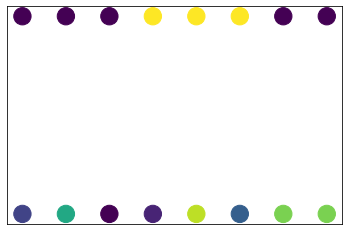

In [211]:
image_values = [0.2, 0.6, 0.0, 0.1, 0.9,0.3, 0.8, 0.8]
initial_guess = [(i//3) % 2 for i in range(len(image_values))]

image_nodes = [ImageNode(c, i, 0) 
               for i, c in enumerate(image_values)]

segmentation_nodes = [SegmentationNode(guess, i, 1)
                      for i, guess in enumerate(initial_guess)]
nodes = image_nodes + segmentation_nodes
colors = [n.value for n in nodes]
node_pos = dict([(node, node.pos()) for node in nodes])

graph = nx.Graph()
for node in nodes:
    graph.add_node(node)
    
nx.draw_networkx_nodes(graph, node_pos, nodes, node_color=colors)


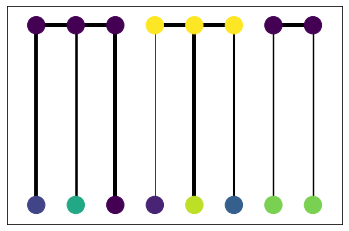

In [212]:
def similarity_energy(seg: SegmentationNode, img: SegmentationNode):
    return (1-(seg.value - img.value)**2)
    
def edge_energy(class1: int, class2: int, weight: float=1):
    return weight if seg1.value == seg2.value else 0

edge_weight = 1

# add energy for being close to image
for img_node, seg_node in zip(segmentation_nodes, image_nodes):
    graph.add_edge(seg_node, img_node,
                   capacity=similarity_energy(seg_node, img_node))

# add energy for being close to neighbor
for seg1, seg2 in zip(segmentation_nodes[:-1], 
                        segmentation_nodes[1:]):
    graph.add_edge(seg1, seg2, 
                   capacity=edge_energy(seg1.value, seg2.value, edge_weight))

edges = graph.edges(data=True)
edge_witdh = [4*edge[2]['capacity'] for edge in edges]

nx.draw_networkx_nodes(graph, node_pos, nodes, node_color=colors)
nx.draw_networkx_edges(graph, node_pos, graph.edges, width=edge_witdh)


15


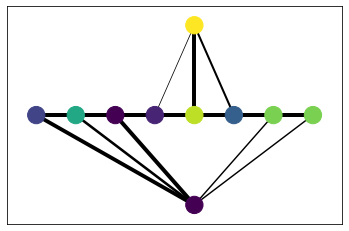

In [221]:
class_0 = ClassNode(0)
class_1 = ClassNode(1)

graph = nx.Graph()
nodes = image_nodes + [class_0, class_1]
colors = [node.value for node in nodes]
node_pos[class_0] = (len(image_nodes)/2, -1)
node_pos[class_1] = (len(image_nodes)/2, 1)

# add energy for being close to image
for seg_node, img_node in zip(segmentation_nodes, image_nodes):
    class_ = class_0 if seg_node.value == 0 else class_1
    graph.add_edge(img_node, class_,
                   capacity=similarity_energy(img_node, class_))

# add energy for being close to neighbor
for i, (img1, img2) in enumerate(zip(image_nodes[:-1], image_nodes[1:])):                
    graph.add_edge(img1, img2, capacity=edge_energy(initial_guess[i], 
                                                    initial_guess[i+1], 
                                                    edge_weight))
    
edges = graph.edges(data=True)
print(len(edges))
edge_witdh = [4*edge[2]['capacity'] for edge in edges]

nx.draw_networkx_nodes(graph, node_pos, image_nodes + [class_0, class_1], 
                       node_color=colors)
nx.draw_networkx_edges(graph, node_pos, graph.edges, width=edge_witdh)


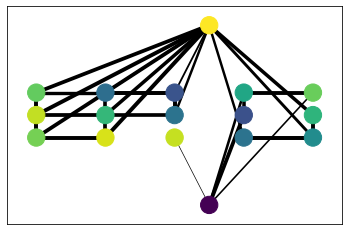

In [208]:
img = random((5,3))
initial_guess = randint(0,2,img.shape)
image_nodes = np.array([ImageNode(value, i, j)
                      for (i, j), value in zip(np.ndindex(img.shape), img.ravel())
                      ]).reshape(img.shape)
graph = nx.Graph()
for node, con in zip(image_nodes.ravel(), initial_guess.ravel()):
    if con == 0:
        graph.add_edge(node, class_0,
                       capacity=similarity_energy(node, class_0))
    if con == 1:
        graph.add_edge(node, class_1,
                       capacity=similarity_energy(node, class_1))
for i, j in np.ndindex(img[:-1, :].shape):
    if not initial_guess[i, j] == initial_guess[i+1, j]:
        continue
    node1, node2 = image_nodes[i, j], image_nodes[i+1, j]
    graph.add_edge(node1, node2, capacity=similarity_energy(node1, node2))

for i, j in np.ndindex(img[:, :-1].shape):
    if not initial_guess[i, j] == initial_guess[i, j+1]:
        continue
    node1, node2 = image_nodes[i, j], image_nodes[i, j+1]
    graph.add_edge(node1, node2, capacity=similarity_energy(node1, node2))
    
node_pos = dict([(n, n.pos()) for n in image_nodes.ravel()])
node_pos[class_0] = ((img.shape[0])/2, -3)
node_pos[class_1] = ((img.shape[0])/2, img.shape[1]+2)

edges = graph.edges(data=True)
edge_witdh = [4*edge[2]['capacity'] for edge in edges]
allnodes = list(image_nodes.ravel()) + [class_0, class_1]
node_color = [n.value for n in allnodes]
nx.draw_networkx_nodes(graph, node_pos, allnodes, node_color=node_color)
nx.draw_networkx_edges(graph, node_pos, graph.edges, edge_witdh)


In [209]:
list(nx.all_neighbors(graph, image_nodes[0,0]))


[ClassNode(value=1),
 ImageNode(value=0.9391691139038945, posx=1, posy=0),
 ImageNode(value=0.9094578272623628, posx=0, posy=1)]